Scraping newspaper articles from derstandard.at
===

* relating to
    * Croatia
    * Serbia
    * Hungary (control I)
    * Slowakia (control II)
* direct search (no intermediate search step via twitter)

I focus on articles from derstandard, because it's among the most popular online newspapers in Austria and because building a scraper for a specific newspaper and scraping itself is a tedious and time-consuming task. This should serve as a proof-of-concept and can later be adapted to include a larger set of Austrian newspapers.

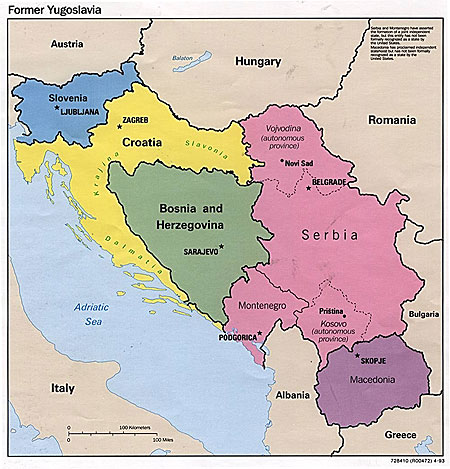

In [1]:
import jupyter_black

jupyter_black.load()

## Imports and functions

In [2]:
import os
import json
import subprocess
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.firefox.options import Options
from time import sleep
import squarify


data_dir = "data/derstandard"

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)


def get_derstandard_article(url):
    """

    Scrapes article from derstandard.at
    and returns title, subtitle and
    complete article text

    """
    try:
        options = Options()
        options.add_argument("-headless")
        driver = webdriver.Firefox(options=options)
        driver.set_script_timeout(30)
        driver.get(url)

        # switch to iframe (when it is avilable) with button and click it
        iframes = driver.find_elements(By.TAG_NAME, "iframe")

        # wait for both iframes to appear
        while len(iframes) < 2:
            iframes = driver.find_elements(By.TAG_NAME, "iframe")

        iframe = iframes[1]
        WebDriverWait(driver, 20).until(
            EC.frame_to_be_available_and_switch_to_it(iframe)
        )
        WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, ".primary"))
        ).click()

        # switch to new window
        new_window = driver.window_handles
        driver.switch_to.window(new_window[0])

        sleep(2)

        if url[:45] == "https://www.derstandard.at/jetzt/livebericht/":
            article_title = driver.find_element(By.ID, "content-header").text
            article_subtitle = ""
            article_text = driver.find_element(By.ID, "content-main").text
            article_date = driver.find_element(By.CLASS_NAME, "date").text

        else:
            article_title = driver.find_element(By.CLASS_NAME, "article-title").text
            article_subtitle = driver.find_element(
                By.CLASS_NAME, "article-subtitle"
            ).text
            article_body = driver.find_element(By.CLASS_NAME, "article-body")
            article_text = article_body.text
            article_date = driver.find_element(By.TAG_NAME, "time").text

        # translate German to English dates
        d = {
            "Jänner": "Jan",
            "Januar": "Jan",
            "Feber": "Feb",
            "Februar": "Feb",
            "März": "Mar",
            "Mai": "May",
            "Juni": "Jun",
            "Juli": "Jul",
            "Oktober": "Oct",
            "Dezember": "Dec",
        }

        article_date = " ".join(d.get(ele, ele) for ele in article_date.split())
        article_date = pd.Timestamp(article_date).isoformat()

    except Exception as e:
        driver.quit()
        print("Could not process url:", url, e)
        return None

    driver.quit()

    return article_title, article_subtitle, article_text, article_date

## Search

### Search words for countries

In [3]:
countries_min = dict(
    serbia="serbien",
    croatia="kroatien",
    slovakia="slowakei",
    hungary="ungarn",
    albania="albanien",
    austria="österreich",
    bosnia="bosnien",
    montenegro="montenegro",
    spain="spanien",
    slovenia="slowenien",
    kosovo="kosovo",
    northmacedonia="mazedonien",
    bulgaria="bulgarien",
    romania="rumänien",
    yugoslavia="jugoslawien",
)

### Define countries of interest

Articles that include Serbia or Yugoslavia (until 2003), but do not include Croatia will be later treated as "Serbia", Articles that include Croatia, but not Serbia or Yugoslavia (until 2003) will be later treated as "Croatia". The reason for this is that "Yugoslavia" was the name for the country later called Serbia (Serbia & Montenegro). To make this visible, I will re-label Yugoslavia-articles between 1998 and 2003 from "jugoslawien" to "serbien".  It's difficult to know whether an article referes to old Yugoslavia before the war or to the country later called Serbia (& Montenegro), but I assume that between 1998 and 2003 the articles refere to the latter. I could be wrong, of course, but excluding these articles could make things worse.

In [4]:
cois = [
    "serbia",
    "yugoslavia",
    "croatia",
    "slovenia",
    "northmacedonia",
    "bosnia",
    "montenegro",
    "kosovo",
    "slovakia",
    "hungary",
    "albania",
]

### Retrieve urls of relevant articles and store them in textfiles

The news archive dates back to 1997, the articles found on the subject are from 1998&ndash;2023. The breakup of Yugoslavia started in 1991, followed by the war in Croatia in the same year and the war in Bosnia in 1992. Armed conflict ended in 1995. In 1998, when the first newspaper articles are available, the war in Kosovo started and lasted until 1999, when NATO started bombing Serbia (back then "Yugoslavia") between March and June.

<div class="alert alert-danger">Run below cell only, if you want to scrape the urls of news articles!</div>

In [ ]:
if os.path.exists(data_dir+"/urls") == False:
    os.makedirs(data_dir+"/urls")

    
# iterate over countries
for coi in cois:

    country = countries_min[coi]

    # iterate over years
    for year in range(1997, 2023 + 1):

        page = 0

        # iterate over pages
        while True:

            page += 1

            url = f"https://www.derstandard.at/search?n=&fd={year}-01-01&td={year}-12-31&s=date&query={country}&p={page}"

            options = Options()
            options.add_argument("-headless")
            driver = webdriver.Firefox(options=options)
            driver.set_script_timeout(30)

            driver.get(url)

            # switch to iframe (when it is avilable) with button and click it
            iframes = driver.find_elements(By.TAG_NAME, "iframe")

            # wait for both iframes to appear
            while len(iframes) < 2:
                iframes = driver.find_elements(By.TAG_NAME, "iframe")

            iframe = iframes[1]

            WebDriverWait(driver, 20).until(
                EC.frame_to_be_available_and_switch_to_it(iframe)
            )

            WebDriverWait(driver, 20).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, ".primary"))
            ).click()

            # switch to new window
            driver.get(url)

            sleep(2)

            article_elements = driver.find_elements(By.CLASS_NAME, "teaser-inner")

            if len(article_elements) == 0:
                driver.quit()
                break

            urls = [
                article.find_element(By.TAG_NAME, "a").get_attribute("href")
                for article in article_elements
            ]

            with open(data_dir + f"/urls/{country}_{year}_{page}.txt", "w") as fp:
                fp.writelines("\n".join(urls))

            driver.quit()

### Create dataframe from textfiles

In [5]:
import glob


txt_files = glob.glob(data_dir + "/urls/*.txt")
l = []

for f in txt_files:
    df_tmp = pd.read_csv(f, names=["url"])
    x = f.replace(data_dir + "/urls", "")[1:-4]
    df_tmp[["country", "year", "page"]] = x.split("_")
    df_tmp["id"] = df_tmp["url"].apply(
        lambda x: x.split("/")[5] if x.split("/")[3] == "jetzt" else x.split("/")[4]
    )
    l.append(df_tmp)

df = pd.concat(l, axis=0, ignore_index=True)
df = df.drop("page", axis=1)

# year from string to int
df["year"] = df["year"].astype(int)

# Re-label Yugoslavia articles between 1998 and 2003 to Serbia
df.loc[
    (df.country == countries_min["yugoslavia"]) & (df.year <= 2003) & (df.year > 1995),
    "country",
] = countries_min["serbia"]

# Drop duplicates (some articles appeared on more than one search result page)
df = df.drop_duplicates(keep="first").reset_index(drop=True)

# show the number of found articles
df.groupby("country").count()[["url"]].rename(columns=dict(url="count")).sort_values(
    "count", ascending=False
)

,count
country,
ungarn,26957
serbien,16520
kroatien,15802
slowakei,14204
slowenien,13888
kosovo,11730
bosnien,9466
mazedonien,5027
montenegro,4703


### Frequency of articles with country keywords


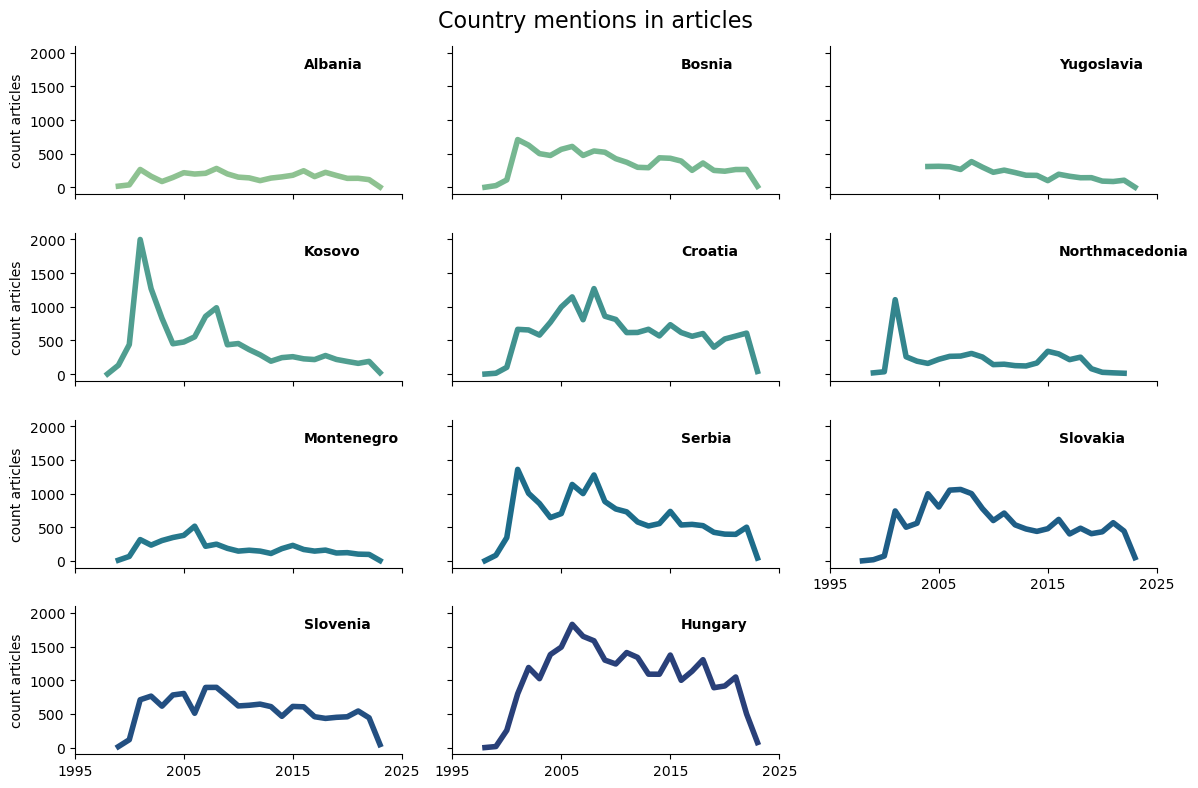

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

df_plt = df.groupby(["country", "year"]).count()[["url"]].reset_index()
df_plt.year = df_plt.year.astype(int)

# Plot each year's time series in its own facet
g = sns.relplot(
    data=df_plt,
    x="year",
    y="url",
    col="country",
    hue="country",
    kind="line",
    palette="crest",
    linewidth=4,
    zorder=5,
    col_wrap=3,
    height=2,
    aspect=2,
    legend=False,
)

# create a reverse dictionary
countries_min_rev = {val: key for (key, val) in countries_min.items()}

# Iterate over each subplot to customize further
for country, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(
        0.7,
        0.85,
        countries_min_rev[country].capitalize(),
        transform=ax.transAxes,
        fontweight="bold",
    )


# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "count articles")
plt.suptitle("Country mentions in articles", fontsize=16)
g.tight_layout()

### Create grouped dataframes

In [7]:
df_grp = (
    df.sort_values("country")
    .groupby(["id", "year", "url"])["country"]
    .apply(list)
    .reset_index()
)

df_grp_no_controls = (
    df.loc[~df["country"].isin(["slowakei", "albanien", "ungarn"])]
    .sort_values("country")
    .groupby(["id", "year", "url"])["country"]
    .apply(list)
    .reset_index()
)


df_grp["country"] = df_grp["country"].apply(lambda x: "_".join(x))
df_grp_no_controls["country"] = df_grp_no_controls["country"].apply(
    lambda x: "_".join(x)
)

country_count = (
    df_grp.groupby("country", as_index=False)
    .count()
    .rename(columns=dict(id="count"))[["country", "count"]]
    .copy()
)
country_count_no_controls = (
    df_grp_no_controls.groupby("country", as_index=False)
    .count()
    .rename(columns=dict(id="count"))[["country", "count"]]
    .copy()
)

### Plot treemaps to visualize the proportions of published articles per keyword

In [8]:
def plot_count(cois, country_count, countries_min, threshold=100, alt_title=None):
    """
    Plot for number of articles for a given country.

    - set cois to empty list for all countries

    """

    filter_list = [countries_min[coi] for coi in cois]

    if cois != []:
        country_count = country_count.loc[
            country_count.country.str.contains("|".join(filter_list))
        ].reset_index(drop=True)
        title_country = ", ".join([coi.capitalize() for coi in cois])
    else:
        title_country = "all countries"

    other_sum = country_count.loc[country_count["count"] < threshold, "count"].sum()
    data = (
        country_count.loc[country_count["count"] >= threshold]
        .copy()
        .reset_index(drop=True)
    )

    data.loc[len(data)] = ["other", other_sum]
    data["country"] = data["country"].str.replace("_", "+\n")

    plt.figure(figsize=(12, 9))
    squarify.plot(
        sizes=data["count"],
        label=data["country"],
        alpha=0.7,
        text_kwargs=dict(fontsize=7),
    )

    plt.axis("off")
    if alt_title == None:
        plt.title(
            f"Articles about {title_country} 1998–now by keywords ($N$ = {country_count['count'].sum():,.0f})"
        )
    else:
        plt.title(
            alt_title
            + f" 1998–now by keywords ($N$ = {country_count['count'].sum():,.0f})"
        )

#### All scraped article urls (incl. control countries)

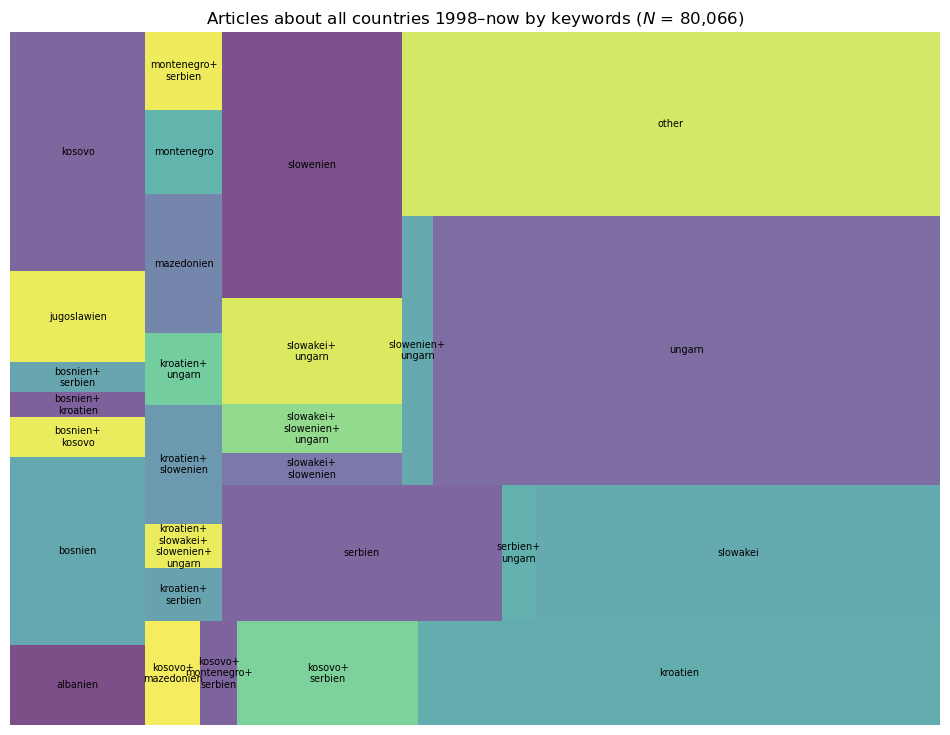

In [9]:
plot_count([], country_count, countries_min, 400)

#### Only article urls that includes former Yugoslav countries (and controls removed)

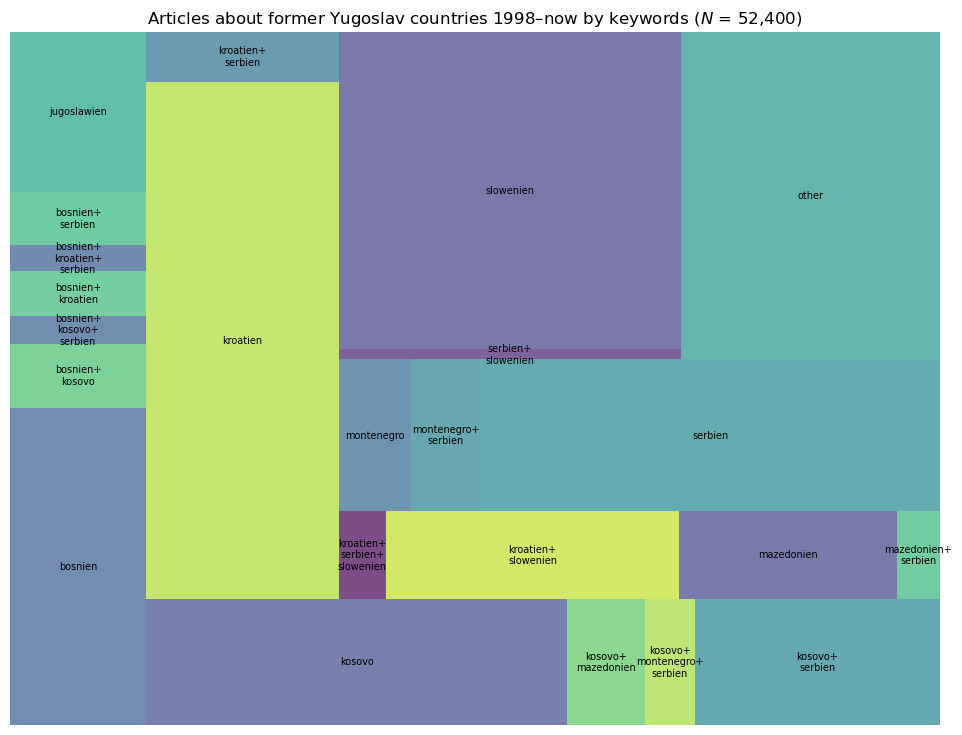

In [10]:
plot_count(
    [
        "yugoslavia",
        "croatia",
        "slovenia",
        "kosovo",
        "bosnia",
        "serbia",
        "montenegro",
        "northmacedonia",
    ],
    country_count_no_controls,
    countries_min,
    250,
    alt_title="Articles about former Yugoslav countries",
)

#### Only article urls that include Serbia (controls removed)

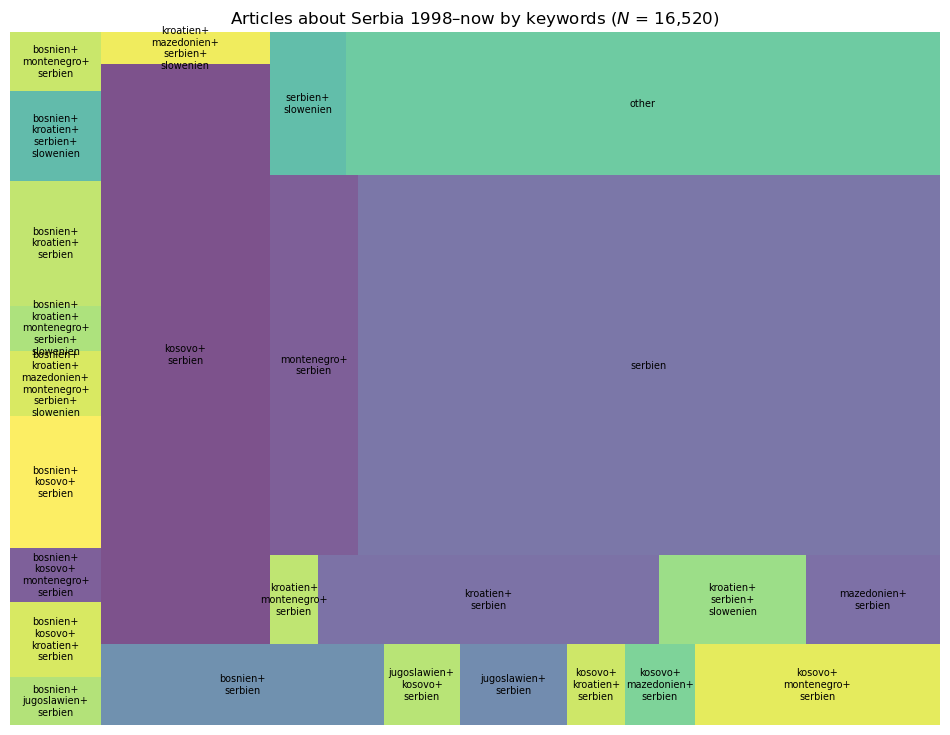

In [11]:
plot_count(["serbia"], country_count_no_controls, countries_min)

#### Only article urls that include Croatia (controls removed)

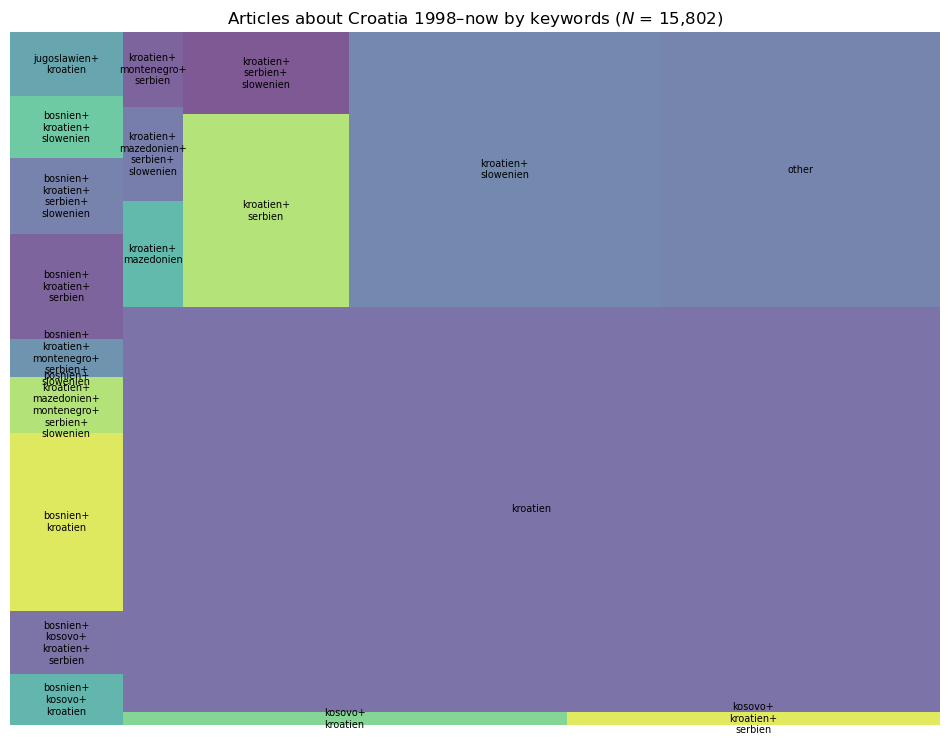

In [12]:
plot_count(["croatia"], country_count_no_controls, countries_min)

## Download

#### Create a sample (in case there are too many articles)

Furthermore, the selection will be narrowed down to articles about 3 countries only.

In [13]:
from numpy import random

random.seed(0)


keyword_filter = ["serbien", "kroatien", "slowenien"]  # only the "pure" articles
max_number_of_articles = 4_740

df_grp_sample = df_grp.copy()
df_grp_sample = df_grp_sample.loc[df_grp_sample.country.isin(keyword_filter)]

df_grp_sample = df_grp_sample.loc[
    df_grp_sample.id.isin(
        random.choice(df_grp_sample.id, size=max_number_of_articles, replace=False)
    )
].reset_index(drop=True)

#### Start downloading

<div class="alert alert-danger">Run below cell only if you want to start downloading the complete darticles</div>

In [ ]:
# sometimes its necessary to set this env variable
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

if os.path.exists(data_dir + "/articles") == False:
    os.makedirs(data_dir + "/articles")


for country in df_grp_sample.country.unique():

    print("Downloading articles for", country)

    df_country = df_grp.copy().loc[df_grp.country == country]

    for _, row in df_country.iterrows():
        filepath = data_dir + f"/articles/{row.id}.json"
        if os.path.exists(filepath) == False:
            try:
                a_title, a_subtitle, a_text, a_date = get_derstandard_article(row.url)
                with open(filepath, "w") as fp:
                    json.dump(
                        dict(
                            date=a_date, title=a_title, subtitle=a_subtitle, text=a_text
                        ),
                        fp,
                    )
            except Exception as e:
                print("Problem with url", row.url, e)
        else:
            pass

### Check what we got

In [14]:
json_files = glob.glob(data_dir + "/articles/*.json")
print(len(json_files), "from", len(df_grp), "are downloaded.")

20327 from 80066 are downloaded.


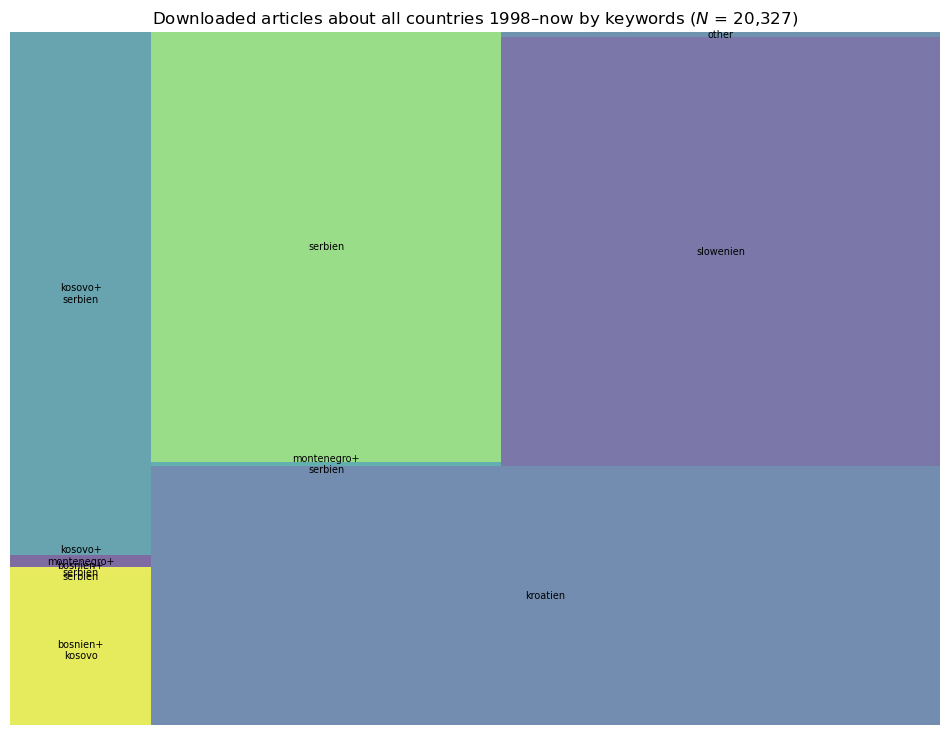

In [15]:
available_ids = list(
    pd.Series(json_files)
    .str.replace("\\", "/", regex=False)
    .str.split("/")
    .map(lambda x: x[-1])
    .str[:-5]
)

df_grp_available = (
    df_grp.loc[df_grp.id.isin(available_ids)].copy().reset_index(drop=True)
)

country_count_available = (
    df_grp_available.groupby("country", as_index=False)
    .count()
    .rename(columns=dict(id="count"))[["country", "count"]]
    .copy()
)

plot_count(
    [],
    country_count_available,
    countries_min,
    20,
    alt_title="Downloaded articles about all countries",
)

We will only work the articles that are purely about either Serbia, Croatia or Slovenia (as a control). Despite the largest of the three countries, articles "solely" about Serbia less frequent than articles about Slovenia and Croatia. This might be due to the fact that Serbia is often mentioned together with other countries because of recent conflicts (Croatia, Kosovo, Bosnia)

## Sentiment analysis

* Pre-processing the text (report steps here)
* Using two different kinds of methods for computing sentiment scores (germansentimen and textblob_de)
* Validity of the 2 methods is checked by comparing them with each other through correlation
    * If correlation is too low then we have to assume that at least one of them doesn't measure the sentiment correctly
    * In this case: As we have no gold-standard to compare them to and we don't know which of the two is poor we can't interpret the results further
    
Correlation coefficient of 0.7 or higher is considered to indicate a high degree of consistency, a coefficient between 0.5 and 0.7 is considered to indicate a moderate consistency, and a coefficient below 0.5 is considered to indicate a poor consistency.

Scores were computed for 1,411 articles and the correlation 0.12. Therefore, sentiment analysis was not further pursued.

### Functions for preprocessing and sentiment scores

In [16]:
# prerequisites:
#!python -m spacy download de_core_news_sm
# nltk.download("stopwords")
# nltk.download('punkt')

import nltk
from num2words import num2words
from nltk.corpus import stopwords
import spacy
import inflect
import regex as re
from germansentiment import SentimentModel
from textblob_de import TextBlobDE as TextBlob


gsm = SentimentModel()
nlp = spacy.load("de_core_news_sm")
p = inflect.engine()
stop_words = set(stopwords.words("german"))


def clean_url(input):
    output = re.sub(r"http\S+", "", input)
    return output


def clean_non_alphanumeric(input):
    alphanumeric = re.sub(r"[^\w]", " ", input)
    return alphanumeric


def clean_tokenization_de(input):
    output = nltk.word_tokenize(input, "german")
    return output


def clean_stopwords(input):
    output = [item for item in input if item not in stop_words]
    return output


def numbers_to_words(input, lang):
    output = []
    for item in input:
        if item.isnumeric() == True:
            output += [num2words(item, lang=lang)]
        else:
            output += [item]
    return output


def clean_lowercase(input):
    output = str(input).lower()
    return output


def clean_lemmatization_de(input):
    output = []
    for ip in input:
        doc = nlp(ip)
        result = " ".join([x.lemma_ for x in doc])
        output.append(result)
    return output


def clean_length(input):
    output = [word for word in input if len(word) > 2]
    return output


def convert_to_string(input):
    output = " ".join(input)
    return output


def remove_custom(input):
    """
    Remove derstandard specific stuff
    such as 'BILD NICHT MEHR VERFÜGBAR'
    """
    output = input.replace("BILD NICHT MEHR VERFÜGBAR", "")
    output = output.replace("APA", "")

    return output


def preprocessing_de(text, remove_stopwords=True, custom=False):
    """
    Preprocessing pipeline for German language.
    """
    if custom:
        text = remove_custom(text)
    text = clean_url(text)
    text = clean_non_alphanumeric(text)
    text = clean_lowercase(text)
    text = clean_tokenization_de(text)
    text = numbers_to_words(text, "de")
    if remove_stopwords:
        text = clean_stopwords(text)
    text = clean_lemmatization_de(text)
    text = clean_length(text)
    text = convert_to_string(text)
    return text


def german_sentiment(txt, with_class=False):
    """

    returns sentiment score for
    German language.

    """

    [class_], [probs] = gsm.predict_sentiment([txt], output_probabilities=True)
    probs = dict(probs)
    if with_class == True:
        return class_, probs["positive"] - probs["negative"]
    return probs["positive"] - probs["negative"]

/home/user/miniconda3/envs/css/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Iterate over all available articles

Load

In [ ]:
# df_grp_available = pd.read_csv(data_dir + "/df_grp_available.csv")

Compute

<div class="alert alert-danger">Run below cell only if you want to start computing sentiment scores for the complete articles!</div>

In [ ]:
df_grp_available["german_sentiment"] = float("nan")
df_grp_available["textblob_de"] = float("nan")

    
for i, row in df_grp_available.iterrows():
    with open(data_dir + f"/articles/{row.id}.json", "r") as fp:
        article = json.load(fp)["text"]

    if pd.isna(row.german_sentiment):  # skip already computed scores
        txt = preprocessing_de(article, custom=True)
        df_grp_available.loc[i, "german_sentiment"] = german_sentiment(txt)
        df_grp_available.loc[i, "textblob_de"] = TextBlob(txt).polarity
        # report progress
        print(str(i)[-1], end="")

Save

In [ ]:
# df_grp_available.to_csv(data_dir + "/df_grp_available.csv", index=False)

Correlation

In [18]:
print(f"N = {len(df_grp_available.dropna())}")

N = 1411


In [195]:
df_grp_available[["german_sentiment", "textblob_de"]].corr()

,german_sentiment,textblob_de
german_sentiment,1.000000,0.120218
textblob_de,0.120218,1.000000


## Word frequency analysis

* As an additional analysis and in case the sentiment analysis turns out inconclusive I count words such as "nationalist", "ultra-nationalist", "regime", "despot", "herrscher", "totalitär", "rechtsradikal", "rechtsextrem", "extremistisch", "faschistisch", "kriegsverbrecher", "kriegsverbrechen" usw.
* These words are also negatively associated and could potentially be seen as a more targeted (political perspective) replacement for the sentiment analysis.
* This should be done only on the unprocessesed text (apply only lowercase)!
* I will build ratios between polemic vs neutral words and check if they differ between the countries and how they change over time.
* But is it so useful to build ratios here? A non-occurence of a control word will lead to a missing value in the ratio. Why not just compute the average occurences of certain words per article?

In [17]:
def compute_frequencies(text, category_list):
    """
    Function to calculate word frequencies.

    """

    count = 0

    for word in category_list:

        count += text.count(word)

    return count

Some bag of words

In [18]:
# maybe also macht, gewalt vs fortschritt, zukunft?

negative_politics = [
    "diktator",
    "tyrann",
    "despot",
    "autokrat",
    "herrscher",
    "führer",
    "machthaber",
    "herrschaft",
    "regime",
    "diktatur",
    # "tyrannis",
    # "despotie",
    # "autokratie",
    "staatsmacht",
    "machtelite",
    "herrschaftselite",
    "regierungsgewalt",
    "staatsgewalt",
    "obrigkeit",
    "unterdrück",
    "staatsgewalt",
    "totalitär",
    "autoritär",
    "mafiastaat",
    "machtfantasie",
    "allmacht",
    "allmächt",
    "herrschen",
    "herrscht",
    "machtzentrum",
]

neutral_politics = [
    "premierminister",
    "premier",
    "präsident",
    "kanzler",
    "parteivorsitzende",
    "regierung",
    "staatsführung",
    "behörde",
    "behördlich" "staatliche institution",
    "staatlicher institution",
    "staatlichen institution",
    "politisch",
    "parlament",
    "nationalrat",
    "minister",
    "repräsentativ",
    "gemeinnütz",
    "politiker",
    "repräsentant",
    "botschaft",
    "regieren",
    "regiert",
    "befugt",
    "befugnis",
]


# divide this into nationalism and war crimes
extremism = [
    "groß-serb",
    "großserb",
    "groß-kroat",
    "großkroat",
    "großslowen",
    "groß-slowen",
    "nationalist",
    #  "ultranationalist",
    #  "ultra-nationalist",
    "rechtsradikal",
    "rechtsextrem",
    "extreme rechte",
    "extremist",
    "faschist",
]

warcrimes = [
    "ethnische säuberung",
    "ethnischer säuberung",
    "ethnischen säuberung",
    "vertreibung",
    "völkermord",
    "massenmord",
    "konzentrationslager",
    "folter",
    "kriegsverbrech",
    "genozid",
]

neutral_other = [
    "mensch",
    "person",
    "mann",
    "frau",
    "land",
    "männer",
    "frauen",
    "länder",
    "bevölkerung",
    "leute",
    "herkunft",
    "hilfe",
    "liberal",
    "konservativ",
    "humanitär",
    "zivil",
    "soldat",
    "armee",
    "militär",
    "helfer",
]

#### Compute frequencies

In [19]:
%%time

from scipy.stats import ttest_ind


df_grp_available["negative_politics"] = float("nan")
df_grp_available["neutral_politics"] = float("nan")
df_grp_available["extremism"] = float("nan")
df_grp_available["warcrimes"] = float("nan")
df_grp_available["neutral_other"] = float("nan")


for i, row in df_grp_available.iterrows():
    with open(data_dir + f"/articles/{row.id}.json", "r") as fp:
        article = json.load(fp)["text"]
        article = article.lower()

    # negative and neutral political leadership
    if pd.isna(row.negative_politics) | pd.isna(
        row.neutral_politics
    ):  # skip already computed scores
        df_grp_available.loc[i, "negative_politics"] = compute_frequencies(
            article, negative_politics
        )
        df_grp_available.loc[i, "neutral_politics"] = compute_frequencies(
            article, neutral_politics
        )

    # other: extremsism, war crimes, neutral
    if (
        pd.isna(row.extremism) | pd.isna(row.neutral_other) | pd.isna(row.warcrimes)
    ):  # skip already computed scores
        df_grp_available.loc[i, "extremism"] = compute_frequencies(article, extremism)
        df_grp_available.loc[i, "warcrimes"] = compute_frequencies(article, warcrimes)
        df_grp_available.loc[i, "neutral_other"] = compute_frequencies(
            article, neutral_other
        )

CPU times: user 19.7 s, sys: 759 ms, total: 20.4 s
Wall time: 23 s


In [20]:
def mean_frequency(df, keyword, group):
    """
    Computes the overall mean frequency and the N of all articles
    for a specific keyword and variable

    """
    return df.loc[df.country == keyword, [group]].mean().values[0], sum(
        df.country == keyword
    )

### Build ratios per year, standardize them and create times series

Higher values indicate a more negative media coverageseriesseries

In [21]:
from scipy.stats import zscore


df_grp_available[
    [
        "z_negative_politics",
        "z_neutral_politics",
        "z_extremism",
        "z_warcrimes",
        "z_neutral_other",
    ]
] = zscore(
    df_grp_available[
        [
            "negative_politics",
            "neutral_politics",
            "extremism",
            "warcrimes",
            "neutral_other",
        ]
    ]
)

df_grp_available["z_ratio_negative_politics"] = (
    df_grp_available["z_negative_politics"] - df_grp_available["z_neutral_politics"]
)
df_grp_available["z_ratio_extremism"] = (
    df_grp_available["z_extremism"] - df_grp_available["z_neutral_other"]
)
df_grp_available["z_ratio_warcrimes"] = (
    df_grp_available["z_warcrimes"] - df_grp_available["z_neutral_other"]
)

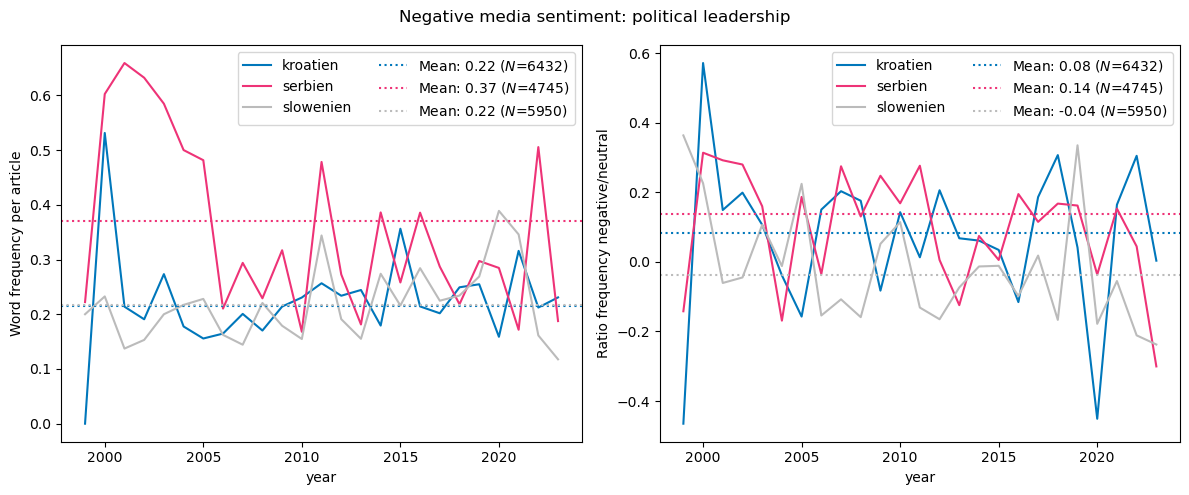

In [22]:
sns.set_palette(
    [
        "#0077BB",
        "#EE3377",
        "#BBBBBB",
        "#33BBEE",
        "#EE7733",
        "#CC3311",
        "#009988",
    ]
)  # vibrant https://personal.sron.nl/~pault/


def timeseries_plot(df, keywords, y1, y2, y1_label=None, y2_label=None, title=""):
    """
    Plots 2 timeseries on 1 figure.

    """

    df_grp = df.groupby(["country", "year"], as_index=False).mean().copy()

    if y1_label == None:
        y1_label = y1
    if y2_label == None:
        y2_label = y2

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.lineplot(
        data=df_grp.loc[df_grp.country.isin(keywords)],
        x="year",
        y=y1,
        hue="country",
        ax=axs[0],
    )

    # mean lines
    for i, kw in enumerate(keywords):
        mean_freq, N = mean_frequency(df, kw, y1)
        axs[0].axhline(
            mean_freq,
            label=f"Mean: {mean_freq:.2f} ($N$={N})",
            color=sns.color_palette()[i],
            linestyle=":",
        )

    axs[0].legend(ncol=2)
    axs[0].set_ylabel(y1_label)

    df_grp_grp = df_grp.groupby(["country", "year"], as_index=False).mean().copy()

    sns.lineplot(
        x="year",
        y=y2,
        hue="country",
        data=df_grp_grp.loc[df_grp_grp.country.isin(keywords)],
        ax=axs[1],
    )

    # mean lines
    for i, kw in enumerate(keywords):
        mean_freq, N = mean_frequency(df, kw, y2)
        axs[1].axhline(
            mean_freq,
            label=f"Mean: {mean_freq:.2f} ($N$={N})",
            color=sns.color_palette()[i],
            linestyle=":",
        )

    axs[1].legend(ncol=2)
    axs[1].set_ylabel(y2_label)

    fig.suptitle(title)
    fig.tight_layout()

    return None


keywords = ["kroatien", "serbien", "slowenien"]

timeseries_plot(
    df_grp_available,
    keywords,
    y1="negative_politics",
    y2="z_ratio_negative_politics",
    y1_label="Word frequency per article",
    y2_label="Ratio frequency negative/neutral",
    title="Negative media sentiment: political leadership",
)

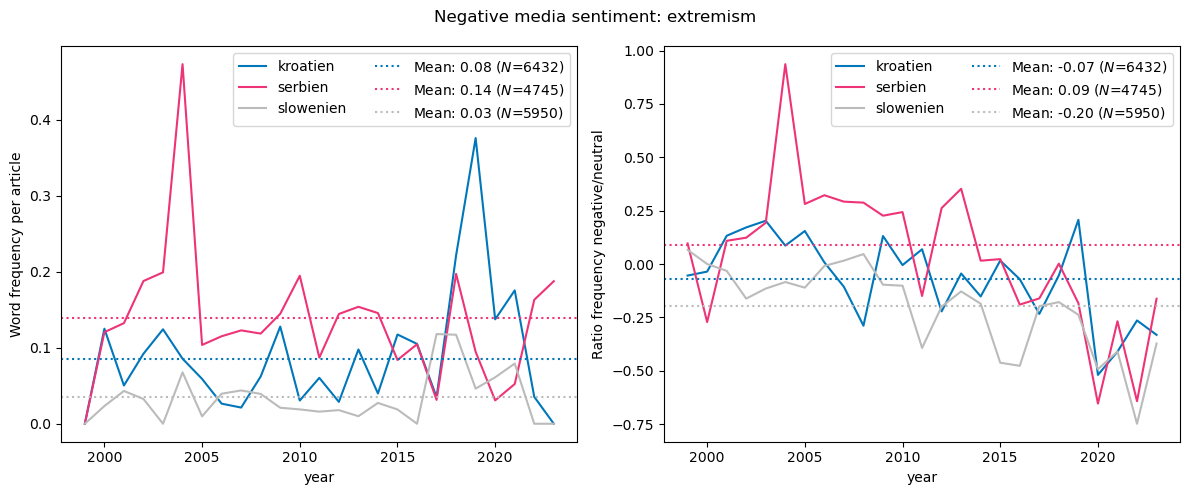

In [23]:
timeseries_plot(
    df_grp_available,
    keywords,
    y1="extremism",
    y2="z_ratio_extremism",
    y1_label="Word frequency per article",
    y2_label="Ratio frequency negative/neutral",
    title="Negative media sentiment: extremism",
)

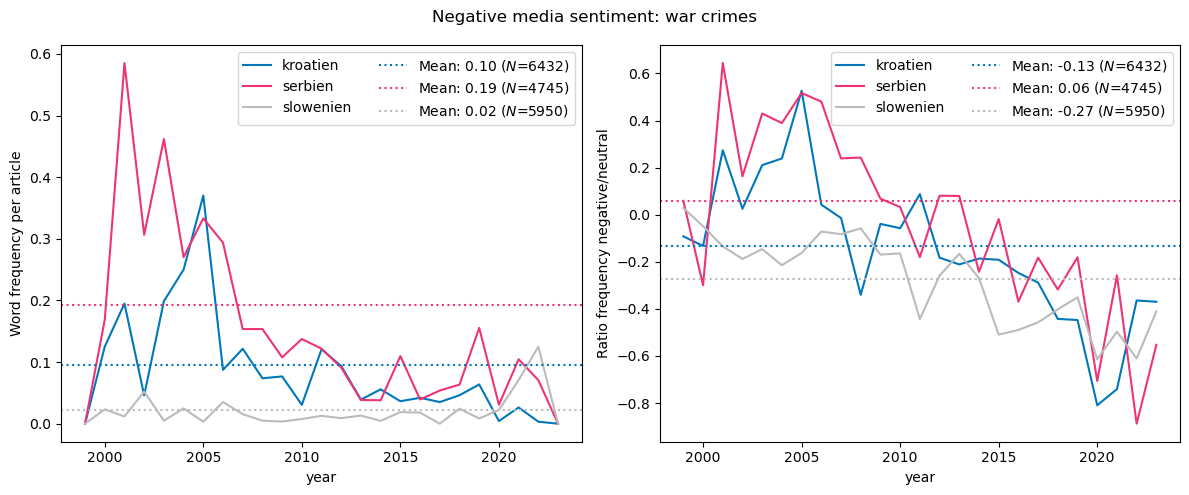

In [24]:
timeseries_plot(
    df_grp_available,
    keywords,
    y1="warcrimes",
    y2="z_ratio_warcrimes",
    y1_label="Word frequency per article",
    y2_label="Ratio frequency negative/neutral",
    title="Negative media sentiment: war crimes",
)

### Permutation tests

In [25]:
def cohens_d(a, b):
    sd = np.sqrt(((a.std()[0] ** 2) + (b.std()[0] ** 2)) / 2)
    m_delta = a.mean()[0] - b.mean()[0]

    return m_delta / sd


def perm_test_srb_cro(df, group):
    a = df.loc[df.country == "serbien", [group]].copy()
    b = df.loc[df.country == "kroatien", [group]].copy()
    _, [pval] = ttest_ind(
        a,
        b,
        permutations=10_000,
        alternative="greater",
    )

    cohensd = cohens_d(
        a,
        b,
    )

    print(group)
    print(f"effect size: {cohensd:.3f}")
    print(f"p-value    : {pval:.3g}\n")


perm_test_srb_cro(df_grp_available, "negative_politics")
perm_test_srb_cro(df_grp_available, "z_ratio_negative_politics")
perm_test_srb_cro(df_grp_available, "extremism")
perm_test_srb_cro(df_grp_available, "z_ratio_extremism")
perm_test_srb_cro(df_grp_available, "warcrimes")
perm_test_srb_cro(df_grp_available, "z_ratio_warcrimes")

negative_politics
effect size: 0.151
p-value    : 0

z_ratio_negative_politics
effect size: 0.045
p-value    : 0.0098

extremism
effect size: 0.097
p-value    : 0

z_ratio_extremism
effect size: 0.108
p-value    : 0

warcrimes
effect size: 0.158
p-value    : 0

z_ratio_warcrimes
effect size: 0.143
p-value    : 0



All results are significant, but that is expected due to the large sample size, the effects though are at best small. It seems that these differences are not relevant.

## Sociodemographic data

* results (word frequency ratios) will be correlated with sociodemographic variables and events, political cycles etc.

### Create dataset

In [26]:
df_events = pd.DataFrame(
    list(range(1998, 2023)),
    columns=["year"],
).set_index("year")

df_events["kosovo_war"] = 0
df_events.loc[:1999, "kosovo_war"] = 1

df_events["montenegro_ind"] = 0
df_events.loc[2006:, "montenegro_ind"] = 1

df_events["kosovo_ind"] = 0
df_events.loc[2008:, "kosovo_ind"] = 1

df_events["syrian_war"] = 0
df_events.loc[2011:, "syrian_war"] = 1

df_events["covid19"] = 0
df_events.loc[2022:, "covid19"] = 1

df_events[["srb_gov_left", "srb_gov_center", "srb_gov_right"]] = 0
df_events[["cro_gov_left", "cro_gov_center", "cro_gov_right"]] = 0

df_events.loc[1997:2003, "srb_gov_left"] = 1
df_events.loc[2004:2011, "srb_gov_center"] = 1
df_events.loc[2012:, "srb_gov_right"] = 1

df_events.loc[1993:1999, "cro_gov_right"] = 1
df_events.loc[2000:2003, "cro_gov_left"] = 1
df_events.loc[2004:2011, "cro_gov_right"] = 1
df_events.loc[2012:2015, "cro_gov_left"] = 1
df_events.loc[2016, "cro_gov_center"] = 1
df_events.loc[2017:, "cro_gov_right"] = 1

df_events.to_csv("data/df_events.csv")

### Correlations

<AxesSubplot:>

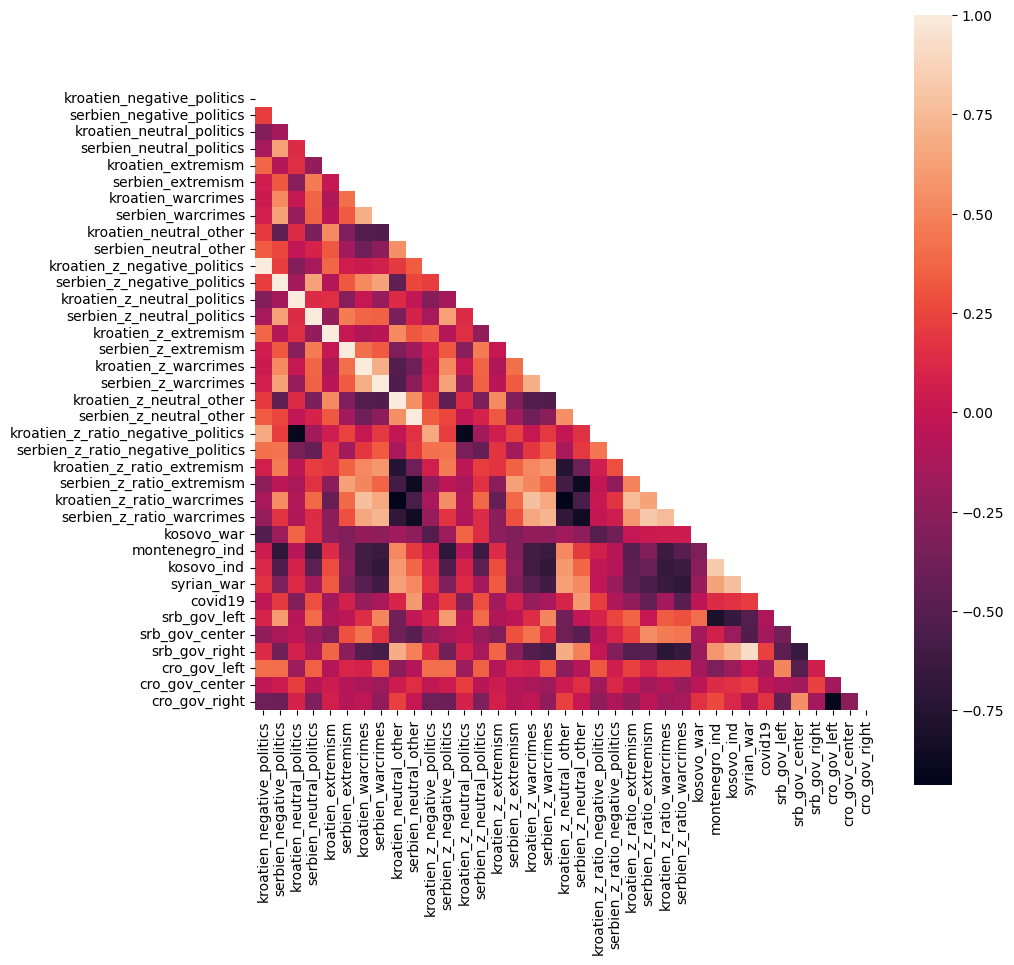

In [27]:
df_for_heatmap = (
    df_grp_available.loc[df_grp_available["country"].isin(["kroatien", "serbien"])]
    .drop("id", axis=1)
    .groupby(["year", "country"], as_index=False)
    .mean()
    .pivot(index="year", columns=["country"])
    .reset_index()
)

df_for_heatmap.columns = [
    re.sub("^_", "", col[1] + "_" + col[0]) for col in df_for_heatmap.columns
]

df_for_heatmap = df_for_heatmap.merge(df_events, on="year").set_index("year")

mask = np.triu(np.ones_like(df_for_heatmap.corr()))

plt.figure(figsize=(10, 10))
sns.heatmap(df_for_heatmap.corr(), square=True, mask=mask)

### Pairwise correlations

In [28]:
from scipy.stats import pearsonr

correlations = {}

for col_a in df_for_heatmap.columns:
    for col_b in df_events.columns:
        correlations[col_a + "__" + col_b] = pearsonr(
            df_for_heatmap.loc[:, col_a], df_for_heatmap.loc[:, col_b]
        )

result = pd.DataFrame.from_dict(correlations, orient="index").reset_index()
result.columns = ["var", "PCC", "p-value"]

result[["var_1", "var_2"]] = result["var"].str.split("__", expand=True)
result = result.drop("var", axis=1).reindex(
    columns=["var_1", "var_2", "PCC", "p-value"]
)

result["val"] = result["PCC"].apply(lambda x: "pos" if x >= 0 else "neg")
result["PCC"] = result["PCC"].abs()

#### Sign. correlations with negative politics

##### Croatia

In [29]:
result.loc[
    (result.var_1 == "kroatien_negative_politics") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val
0,kroatien_negative_politics,kosovo_war,0.516266,0.009804,neg
1,kroatien_negative_politics,cro_gov_left,0.411405,0.045791,pos


In [30]:
result.loc[
    (result.var_1 == "kroatien_z_ratio_negative_politics") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val
0,kroatien_z_ratio_negative_politics,kosovo_war,0.512878,0.010383,neg


##### Serbia

In [31]:
result.loc[
    (result.var_1 == "serbien_negative_politics") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val
0,serbien_negative_politics,montenegro_ind,0.696216,0.000158,neg
1,serbien_negative_politics,srb_gov_left,0.603721,0.001786,pos
2,serbien_negative_politics,kosovo_ind,0.533293,0.007285,neg
3,serbien_negative_politics,cro_gov_right,0.407676,0.047991,neg


In [32]:
result.loc[
    (result.var_1 == "serbien_z_ratio_negative_politics") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val


#### Sign. correlations with extremism

##### Croatia

In [33]:
result.loc[
    (result.var_1 == "kroatien_extremism") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val


In [34]:
result.loc[
    (result.var_1 == "kroatien_z_ratio_extremism") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val
0,kroatien_z_ratio_extremism,srb_gov_right,0.512185,0.010504,neg
1,kroatien_z_ratio_extremism,montenegro_ind,0.499711,0.012906,neg
2,kroatien_z_ratio_extremism,kosovo_ind,0.472558,0.019709,neg
3,kroatien_z_ratio_extremism,syrian_war,0.456489,0.024945,neg


##### Serbia

In [35]:
result.loc[
    (result.var_1 == "serbien_extremism") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val


In [36]:
result.loc[
    (result.var_1 == "serbien_z_ratio_extremism") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val
0,serbien_z_ratio_extremism,syrian_war,0.556383,0.004750,neg
1,serbien_z_ratio_extremism,srb_gov_center,0.538981,0.006575,pos
2,serbien_z_ratio_extremism,srb_gov_right,0.507525,0.011354,neg
3,serbien_z_ratio_extremism,covid19,0.436160,0.033115,neg
4,serbien_z_ratio_extremism,kosovo_ind,0.418632,0.041751,neg


#### Sign. correlations with mentions of war crimes

##### Croatia

In [37]:
result.loc[
    (result.var_1 == "kroatien_warcrimes") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val
0,kroatien_warcrimes,montenegro_ind,0.597171,0.002063,neg
1,kroatien_warcrimes,kosovo_ind,0.591214,0.002346,neg
2,kroatien_warcrimes,srb_gov_right,0.520749,0.009080,neg
3,kroatien_warcrimes,syrian_war,0.488397,0.015458,neg
4,kroatien_warcrimes,srb_gov_center,0.428505,0.036693,pos


In [38]:
result.loc[
    (result.var_1 == "kroatien_z_ratio_warcrimes") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val
0,kroatien_z_ratio_warcrimes,srb_gov_right,0.713962,0.000089,neg
1,kroatien_z_ratio_warcrimes,kosovo_ind,0.673335,0.000311,neg
2,kroatien_z_ratio_warcrimes,syrian_war,0.648073,0.000616,neg
3,kroatien_z_ratio_warcrimes,montenegro_ind,0.622277,0.001166,neg
4,kroatien_z_ratio_warcrimes,srb_gov_center,0.463090,0.022673,pos


##### Serbia

In [39]:
result.loc[
    (result.var_1 == "serbien_warcrimes") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val
0,serbien_warcrimes,kosovo_ind,0.675863,0.000289,neg
1,serbien_warcrimes,montenegro_ind,0.640364,0.000750,neg
2,serbien_warcrimes,syrian_war,0.603164,0.001808,neg
3,serbien_warcrimes,srb_gov_right,0.581550,0.002876,neg
4,serbien_warcrimes,srb_gov_left,0.514673,0.010073,pos


In [40]:
result.loc[
    (result.var_1 == "serbien_z_ratio_warcrimes") & (result["p-value"] < 0.05)
].sort_values("PCC", ascending=False).reset_index(drop=True)

,var_1,var_2,PCC,p-value,val
0,serbien_z_ratio_warcrimes,syrian_war,0.696194,0.000158,neg
1,serbien_z_ratio_warcrimes,srb_gov_right,0.659745,0.000453,neg
2,serbien_z_ratio_warcrimes,kosovo_ind,0.632349,0.000915,neg
3,serbien_z_ratio_warcrimes,covid19,0.497857,0.013298,neg
4,serbien_z_ratio_warcrimes,montenegro_ind,0.489719,0.015140,neg
5,serbien_z_ratio_warcrimes,srb_gov_center,0.447116,0.028483,pos


## Explorative: Extract authors



In [ ]:
#
#
#

## Explorative: The underlying topics

<div class="alert alert-warning">Preprocessing for word clouds is very time consuming, therefore I just use a small sample to demonstrate the method.</div>

This should only serve as a starting point for further elaboration.

### Wordclouds

In [62]:
from wordcloud import WordCloud


def plot_wordcloud(word_string, name="", max_words=20):
    """
    plots a figure with wordcloud
    """

    word_string = re.sub(",|\.|--|!|\?|:|\"|\(|\)|\[|\]|\s-\s|/|'s|'", " ", word_string)

    wordcloud = WordCloud(
        collocations=False,
        max_font_size=100,
        width=800,
        height=600,
        colormap="Set2",
        max_words=max_words,
        background_color="white",
    ).generate(word_string)

    if name != "":
        name = "_" + name + "_"

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("wordcloud" + name + ".png")
    plt.show()


def load_text_by_keyword(df, keyword, n_samples=150, preprocess=True):
    """
    Loads article texts from json files.

    Ues n_samples=-1 to load all articles.

    """

    txt = ""
    df_sample = df.loc[df["country"] == keyword].copy()
    if n_samples >= 0:
        df_sample = df_sample.loc[random.choice(df_sample.index, n_samples)]

    for i, row in df_sample.iterrows():
        with open(data_dir + f"/articles/{row.id}.json", "r") as fp:
            article = json.load(fp)["text"]
            txt += article.lower()
    if preprocess == True:
        txt_pp = preprocessing_de(txt)
        return txt, txt_pp
    else:
        return txt

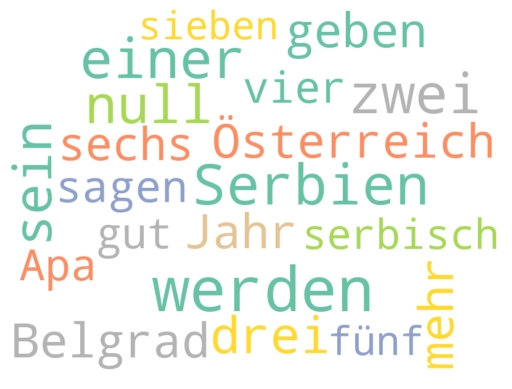

CPU times: user 2min 13s, sys: 34.8 ms, total: 2min 14s
Wall time: 2min 14s


In [55]:
%%time

_, txt_pp_srb = load_text_by_keyword(df_grp_available, "serbien", n_samples=150)
plot_wordcloud(txt_pp_srb)

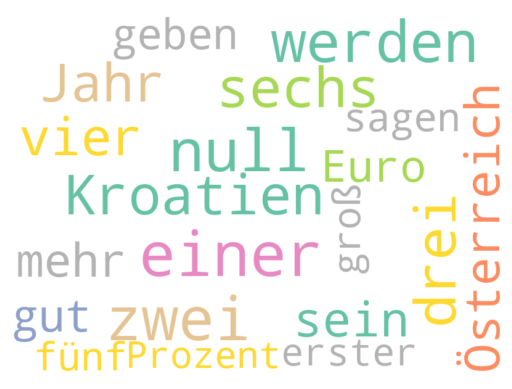

CPU times: user 2min 48s, sys: 31.3 ms, total: 2min 48s
Wall time: 2min 49s


In [60]:
%%time

_, txt_pp_cro = load_text_by_keyword(df_grp_available, "kroatien", n_samples=150)
plot_wordcloud(txt_pp_cro)

### Fuzzy topic modeling

* Extract underlying topics of articles
* Are there significant differences in the topics between articles about Croatia and articles about Serbia?

#### Serbia

In [101]:
%%time

txt_srb = load_text_by_keyword(
    df_grp_available, "serbien", n_samples=-1, preprocess=False
)

for s in stop_words:
    txt_srb = txt_srb.replace(s, "")

CPU times: user 5.49 s, sys: 1.2 s, total: 6.69 s
Wall time: 7.88 s


In [ ]:
#!pip install bertopic
# pip install bertopic[visualization]

from bertopic import BERTopic

# create model
model_srb = BERTopic(language="German", nr_topics=20)

# convert to list
docs_srb = txt_srb.split("\n")

topics_srb, probabilities_srb = model_srb.fit_transform(docs_srb)

In [ ]:
model_srb.visualize_topics()

In [ ]:
model_srb.visualize_barchart()

In [ ]:
model_srb.visualize_heatmap()

Peter Handke, Business, Djokovic, Football are easily idenfifyable topics

#### Croatia

In [ ]:
txt_cro = load_text_by_keyword(
    df_grp_available, "kroatien", n_samples=-1, preprocess=False
)

for s in stop_words:
    txt_cro = txt_cro.replace(s, "")

In [ ]:
# create model
model_cro = BERTopic(language="German", nr_topics=20)

# convert to list
docs_cro = txt_cro.split("\n")

topics_cro, probabilities_cro = model_cro.fit_transform(docs_cro)

In [ ]:
model_cro.visualize_topics()

In [ ]:
model_cro.visualize_barchart()

In [ ]:
model_cro.visualize_heatmap()

Conclusion FTM: Data preprocessing not good enough. "APA", "Weiterlesen", etc should be removed.

## Discussion

* This project does not aim to make a guess about the reasons of more or less negative media coverage nor does it aim to make a judgement whether negative media coverage is justified or not. It only want to shed light whether there are differences in media coverage and how they show.
* In case correlations are low mention that sentiment score methods need to be evaluated for these kind of texts (German) as well as the pre-processing. In a follow-up step we could draw a sample of articles translate them to English and check if the english methods converge better (vader, textblob, ...).
* What do the results tell us? It can be both, showing the reality in these countries or a media bias. You can't tell it from the data.
* There could be some bias in the data because of famous people in Austria which leads to more mentions of a specific country in a specific way. We haven't controlled for that.
* Some years are more articles then others, this will lead to more robust results in some years compared to others. This reflects also in the randomly sampled distribution of the articles. To avoid this in the future we could use rejection sampling to reach a uniform distribution in the sample. 
* The choice of control word is an arbitrary one, finding good control words is essential as it can influence the whole outcome. A different set of neutral control words would be needed to verify the results and make sure that the choice of control words biased the results.
* Sociodemographic data is not very precise, party direction not always so simple etc., lag analysis would be interesting.